In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats.mstats import pearsonr, spearmanr

In [2]:
file = '/Users/irffanalahi/Research/Research_update/SoftRD/largerEXP/genepromdelta.7/Randomforest/developing/onPBMC/corr/withDC/allmethodsum/perctcorr/BL14_genepromSM_0.7.txt_bestref.txt_result_dupindex_binnedstats.pkladjustedScore_minus_avg_CSxOut.txt_7PBMC_cytofv2.txt'

data = pd.read_csv(file, sep='\t', index_col=0)

df = pd.DataFrame(data)

In [3]:
cols = []
for cell in list(df.columns):
    if '.x' in cell:
        cols.append(cell.split('.')[0])
    elif '.y' in cell:
        cols.append(cell.split('.')[0] + '_real')
    else:
        cols.append(cell)
df.columns = cols

In [4]:
samples = list(df.index)
columns = list(df.columns)
new_columns = []
for col in columns:
    if '_real' in col:
        new_columns.append(col.split('_')[0])
        
print(new_columns)

['CD4', 'CD8', 'Tr', 'mB', 'nB', 'm4', 'm8', 'Mn', 'NK', 'DC']


In [5]:
def generate_df_dic(correlation, df, columns):
    df_corr = {}
    df = df.loc[samples, :]
    for cell in columns:
        if cell in df.columns:
            corr = correlation(list(df[cell]), list(df[cell + '_real']))[0]
            df_corr[cell] = corr
        else:
            df_corr[cell].append(float('NaN'))
    return df_corr

def linear_reg(df, columns):
    df_reg = {}
    for cell in columns:
        GT = np.array(df[cell + '_real'])
        RC = np.array(df[cell])
        df_reg[cell] = np.polyfit(GT, RC, 1)
    return df_reg

In [6]:
pearson_dic = generate_df_dic(pearsonr, df, new_columns)
spearman_dic = generate_df_dic(spearmanr, df, new_columns)
reg = linear_reg(df, new_columns)

In [7]:
def renamect(act):
    if act=='CD4':
        return 'Naive CD4 T'
    if act=='CD8':
        return 'Naive CD8 T'
    if act=='Tr':
        return 'Tregs'
    if act=='mB':
        return 'Memory B'
    if act=='nB':
        return 'Naive B'
    if act=='m4':
        return 'Memory CD4 T'
    if act=='m8':
        return 'Memory CD8 T'
    if act=='Mn':
        return 'Mono'
    return act

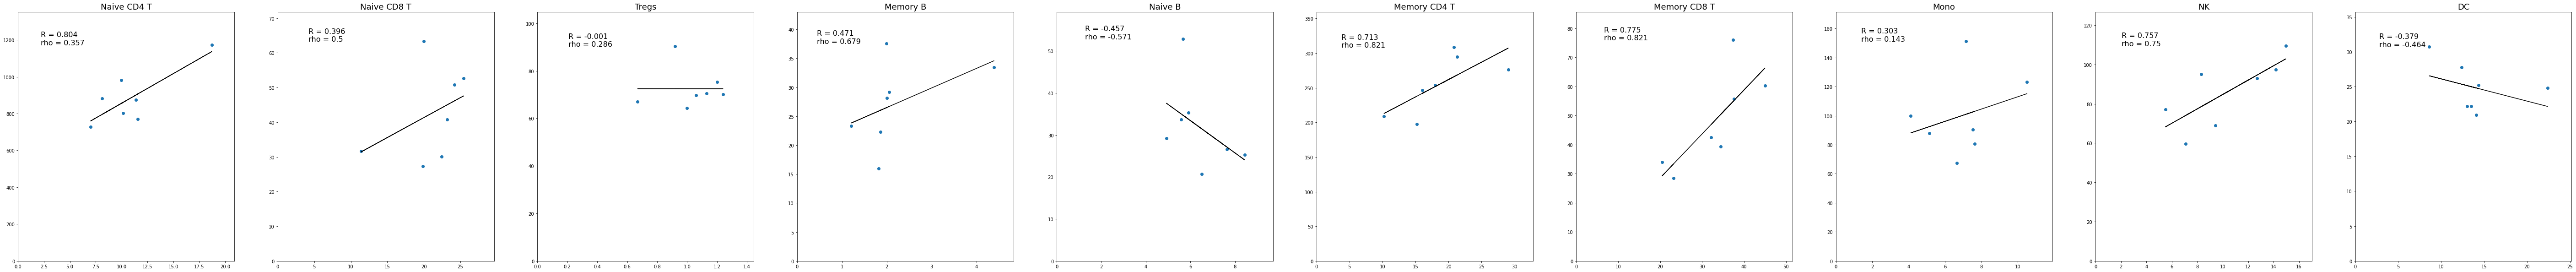

In [8]:
fig, axs = plt.subplots(1, len(new_columns), figsize=(len(new_columns) * 10, 10))

for i, cell in enumerate(new_columns):
    GT = np.array(df[cell + '_real'])
    RC = np.array(df[cell])
    axs[i].scatter(GT, RC)
    axs[i].set_xlim(0, max(GT) + np.mean(GT) / 5)
    axs[i].set_ylim(0, max(RC) + np.mean(RC) / 5)
    m = reg[cell][0]
    b = reg[cell][1]
    axs[i].plot(GT, GT * m + b, c='k')
    #axs[i].set_xlabel('Ground Truth', fontsize=16)
    #axs[i].set_ylabel('Read Counting', fontsize=16)
    
    rnamedcell=renamect(cell)
    
    axs[i].set_title(rnamedcell, fontsize=18)
    corrs = 'R = ' + str(np.around(pearson_dic[cell], decimals=3)) + '\nrho = ' + str(np.around(spearman_dic[cell], decimals=3))
    axs[i].annotate(corrs, xy = (np.mean(GT) / 5, max(RC)), fontsize=16)

plt.savefig(file+ '_cellcorr.pdf', bbox_inches='tight')